In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import scipy.stats as stats
import seaborn as sns

%matplotlib inline


In [92]:
current_dir = os.getcwd()
filename = '13 million Duolingo student learning traces.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/', filename))

df = pd.read_csv(filepath)

# Take a sample of dataframe 
df = df.sample(500000)

In [3]:
""" 
p_recall - session_correct/session_seen
timestamp - UNIX timestamp of the current lesson
delta - time (in seconds) since the last lesson that included this word
user_id - student user ID
learning_language - language being learned
ui_language - user interface language (presumably native to the student)
lexeme_id - system ID for the lexeme tag (i.e., word)
lexeme_string - lexeme tag for word
history_seen - total times user has seen the word prior to this lesson
history_correct - total times user has been correct for the word prior to this lesson
session_seen - times the user saw the word during this lesson
session_correct - times the user got the word correct during this lesson
"""


' \np_recall - session_correct/session_seen\ntimestamp - UNIX timestamp of the current lesson\ndelta - time (in seconds) since the last lesson that included this word\nuser_id - student user ID\nlearning_language - language being learned\nui_language - user interface language (presumably native to the student)\nlexeme_id - system ID for the lexeme tag (i.e., word)\nlexeme_string - lexeme tag for word\nhistory_seen - total times user has seen the word prior to this lesson\nhistory_correct - total times user has been correct for the word prior to this lesson\nsession_seen - times the user saw the word during this lesson\nsession_correct - times the user got the word correct during this lesson\n'

In [4]:
df.reset_index(inplace=True, drop=True)
df.drop('timestamp', axis=1, inplace=True)
df

,p_recall,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,894695,u:irDJ,es,en,2d8e4defa44f2512883a85f2c0ea46b4,ropa/ropa<n><f><sg>,1,1,2,2
1,1.0,1134,u:eTel,fr,en,be70637289b60b17de3b22270462e5bf,un/un<det><ind><m><sg>,42,39,2,2
2,0.5,143,u:dmnS,en,pt,928787744a962cd4ec55c1b22cedc913,eats/eat<vblex><pri><p3><sg>,77,67,2,1
3,1.0,1081,u:h8c3,en,pt,17632879145d3e2737d11a3a5053dd50,his/his<det><pos><sp>,2,2,1,1
4,1.0,58249,u:P03,de,en,2ac4ffe95f75b15d1d99aeebbb8321c7,ist/sein<vbser><pri><p3><sg>,4,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...
499995,1.0,429,u:hkg0,fr,en,8bd6d060bb604e17c936418f835d87c8,mon/mon<det><pos><m><sg>,16,15,2,2
499996,1.0,24925,u:ceI_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,559,494,1,1
499997,1.0,133,u:fKnT,en,es,b3240d21fd450022647d50a64c18cace,speak/speak<vblex><pres>,6,6,2,2
499998,1.0,468170,u:iPPc,en,es,55f383178cf0fdc463ef1ebf91bd288d,milk/milk<n><sg>,2,1,4,4


In [5]:
# Check the types
df.dtypes

p_recall             float64
delta                  int64
user_id               object
learning_language     object
ui_language           object
lexeme_id             object
lexeme_string         object
history_seen           int64
history_correct        int64
session_seen           int64
session_correct        int64
dtype: object

In [6]:
# Check for na
df.isna().any()

p_recall             False
delta                False
user_id              False
learning_language    False
ui_language          False
lexeme_id            False
lexeme_string        False
history_seen         False
history_correct      False
session_seen         False
session_correct      False
dtype: bool

In [7]:
# Check for duplicates
df.duplicated().any()

np.False_

In [5]:
# Create new column ui language - learning language 
df['lang'] = df['learning_language'] + '-' + df['ui_language']

In [6]:
# Get numeric columns 
df_numeric = df.select_dtypes(np.number)
features = df_numeric.columns.tolist()

# Get object columns  
df_obj = df.select_dtypes(include='object')

In [7]:
"""
p_recall (proportion of correct answers to total answers in one session): the mean is 0.9, the median is 1. More than 75% users can answer all questions correctly in one session. 
delta: the mean is 3.36 days between sessions, the median is 0.35 day. Max value is 466 days, 75% users have less than 5.12 days between sessions. Likely outliers. 
history_seen: median is 6 times seen prior to this session, the max is very high (13 518)
history_correct: mean is 6 times correct, standard deviation is very high. 
session_seen: usually around 1 time seen during session, mean 1.8. 
session_correct: mean 1.6, median 1.0 
"""

'\np_recall (proportion of correct answers to total answers in one session): the mean is 0.9, the median is 1. More than 75% users can answer all questions correctly in one session. \ndelta: the mean is 3.36 days between sessions, the median is 0.35 day. Max value is 466 days, 75% users have less than 5.12 days between sessions. Likely outliers. \nhistory_seen: median is 6 times seen prior to this session, the max is very high (13 518)\nhistory_correct: mean is 6 times correct, standard deviation is very high. \nsession_seen: usually around 1 time seen during session, mean 1.8. \nsession_correct: mean 1.6, median 1.0 \n'

In [8]:
# Describe numerical columns 
df.describe().map(lambda x: f"{x:0.3f}")

,p_recall,delta,history_seen,history_correct,session_seen,session_correct
count,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000
mean,0.896,725812.854,22.109,19.462,1.820,1.646
std,0.271,2238025.693,134.431,117.320,1.366,1.324
min,0.000,1.000,1.000,1.000,1.000,0.000
25%,1.000,529.000,3.000,3.000,1.000,1.000
50%,1.000,76664.000,6.000,6.000,1.000,1.000
75%,1.000,438430.750,15.000,13.000,2.000,2.000
max,1.000,39758317.000,13517.000,12887.000,20.000,19.000


In [9]:
# Describe by language
for column in features:
    print('Stats for:', column)
    print(df.groupby('learning_language')[column].describe())

Stats for: p_recall
                      count      mean       std  min  25%  50%  75%  max
learning_language                                                       
de                  56430.0  0.894710  0.276963  0.0  1.0  1.0  1.0  1.0
en                 195297.0  0.897278  0.268206  0.0  1.0  1.0  1.0  1.0
es                 132535.0  0.898650  0.269057  0.0  1.0  1.0  1.0  1.0
fr                  72644.0  0.882989  0.283390  0.0  1.0  1.0  1.0  1.0
it                  31060.0  0.910144  0.256181  0.0  1.0  1.0  1.0  1.0
pt                  12034.0  0.904166  0.264521  0.0  1.0  1.0  1.0  1.0
Stats for: delta
                      count           mean           std   min    25%  \
learning_language                                                       
de                  56430.0  955567.642336  2.955178e+06   1.0  756.0   
en                 195297.0  655751.496618  1.950808e+06   1.0  463.0   
es                 132535.0  851633.248659  2.555774e+06   1.0  731.5   
fr            

In [10]:
# Describe categorical columns
df.describe(include=['O'])

,user_id,learning_language,ui_language,lexeme_id,lexeme_string,lang
count,500000,500000,500000,500000,500000,500000
unique,75467,6,4,11224,11007,8
top,u:bcH_,en,en,827a8ecb89f9b59ac5c29b620a5d3ed6,a/a<det><ind><sg>,en-es
freq,796,195297,304703,4771,4771,141810


In [11]:
z = np.abs(stats.zscore(df_numeric))       
print(z.max())

p_recall             3.307801
delta               17.440614
history_seen       100.385724
history_correct    109.679497
session_seen        13.309368
session_correct     13.109370
dtype: float64


In [29]:
# Numeric analysis -> outliers
threshold_z = 3
z = np.abs(stats.zscore(df_numeric))   
df = df[(z < threshold_z).all(axis=1)]


print("Original DataFrame Shape:", df_numeric.shape[0])
print("DataFrame Shape after Removing Outliers:", df.shape[0])
print('Rows removed', df_numeric.shape[0]- df.shape[0])


df_numeric = df.select_dtypes(np.number)
print('Z after removal', np.abs(stats.zscore(df_numeric)).max())  


# Delete also individually for columns
# outlier_indices = np.where(z > threshold_z)[0]
# no_outliers = df_diabetics.drop(outlier_indices)


Original DataFrame Shape: 442493
DataFrame Shape after Removing Outliers: 390845
Rows removed 51648
Z after removal p_recall           5.344113
delta              5.156886
history_seen       6.119558
history_correct    6.064657
session_seen       2.601872
session_correct    2.827662
dtype: float64


In [30]:
# Describe after removal 
df.describe().map(lambda x: f"{x:0.3f}")

,p_recall,delta,history_seen,history_correct,session_seen,session_correct
count,390845.000,390845.000,390845.000,390845.000,390845.000,390845.000
mean,0.988,325631.819,12.393,11.204,1.624,1.584
std,0.060,609746.928,16.277,14.807,0.913,0.855
min,0.667,1.000,1.000,1.000,1.000,1.000
25%,1.000,486.000,3.000,3.000,1.000,1.000
50%,1.000,60688.000,6.000,6.000,1.000,1.000
75%,1.000,344612.000,14.000,13.000,2.000,2.000
max,1.000,3470023.000,112.000,101.000,4.000,4.000


In [31]:
# langs_sizes = df.groupby(["ui_language", "learning_language"]).size().to_frame('count')
# langs_sizes['% obs'] = (langs_sizes['count']/langs_sizes['count'].sum())*100
# langs_sizes

langs_sizes = df.groupby(['lang']).size().to_frame('count')
langs_sizes['% obs'] = (langs_sizes['count']/langs_sizes['count'].sum())*100
langs_sizes

target_langs = df.groupby(['learning_language']).size().to_frame('count')
target_langs['% obs'] = (target_langs['count']/target_langs['count'].sum())*100
target_langs

,count,% obs
learning_language,,
de,44127,11.290153
en,150133,38.412414
es,105424,26.973353
fr,55029,14.079494
it,26377,6.748711
pt,9755,2.495874


In [32]:
sessions_size = df.groupby(["session_seen", "session_correct"]).size().to_frame('count')
sessions_size['% obs [total]'] = round((sessions_size['count']/sessions_size['count'].sum())*100,2)

sessions_size

count  % obs [total]
session_seen session_correct                       
1            1                241051          61.67
2            2                 78598          20.11
3            2                  9840           2.52
             3                 38403           9.83
4            3                  6019           1.54
             4                 16934           4.33

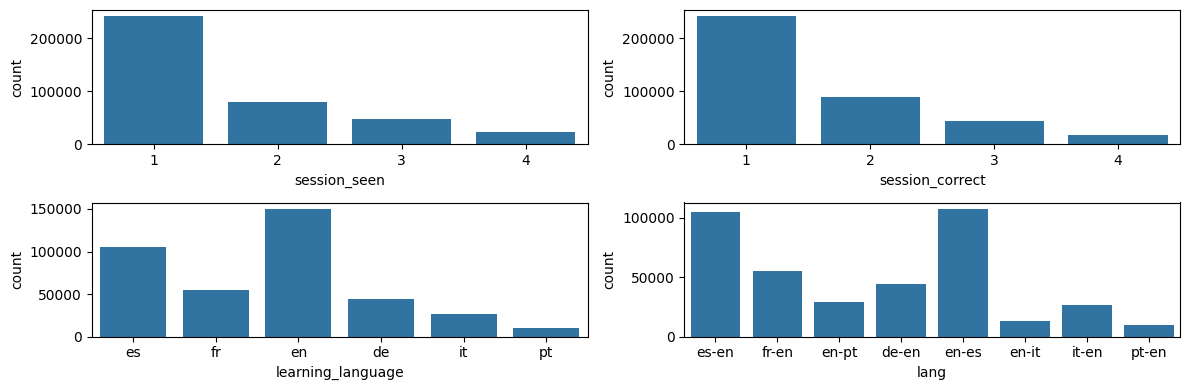

In [33]:
# For ints and objects! 
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))
sns.countplot(x='session_seen', data=df, ax=axes[0,0])
sns.countplot(x='session_correct', data=df, ax=axes[0,1])
sns.countplot(x='learning_language', data=df, ax=axes[1,0])
sns.countplot(x='lang', data=df, ax=axes[1,1])
plt.tight_layout()
plt.show()



In [22]:
features

['p_recall',
 'delta',
 'history_seen',
 'history_correct',
 'session_seen',
 'session_correct']

In [27]:
df

,p_recall,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,lang
0,1.0,894695,u:irDJ,es,en,2d8e4defa44f2512883a85f2c0ea46b4,ropa/ropa<n><f><sg>,1,1,2,2,es-en
1,1.0,1134,u:eTel,fr,en,be70637289b60b17de3b22270462e5bf,un/un<det><ind><m><sg>,42,39,2,2,fr-en
2,0.5,143,u:dmnS,en,pt,928787744a962cd4ec55c1b22cedc913,eats/eat<vblex><pri><p3><sg>,77,67,2,1,en-pt
3,1.0,1081,u:h8c3,en,pt,17632879145d3e2737d11a3a5053dd50,his/his<det><pos><sp>,2,2,1,1,en-pt
4,1.0,58249,u:P03,de,en,2ac4ffe95f75b15d1d99aeebbb8321c7,ist/sein<vbser><pri><p3><sg>,4,4,2,2,de-en
...,...,...,...,...,...,...,...,...,...,...,...,...
499994,0.5,1199,u:i34D,en,es,91e1f511d532b80f8ef3fca752f3a237,fish/fish<n><sg>,2,2,2,1,en-es
499995,1.0,429,u:hkg0,fr,en,8bd6d060bb604e17c936418f835d87c8,mon/mon<det><pos><m><sg>,16,15,2,2,fr-en
499997,1.0,133,u:fKnT,en,es,b3240d21fd450022647d50a64c18cace,speak/speak<vblex><pres>,6,6,2,2,en-es
499998,1.0,468170,u:iPPc,en,es,55f383178cf0fdc463ef1ebf91bd288d,milk/milk<n><sg>,2,1,4,4,en-es


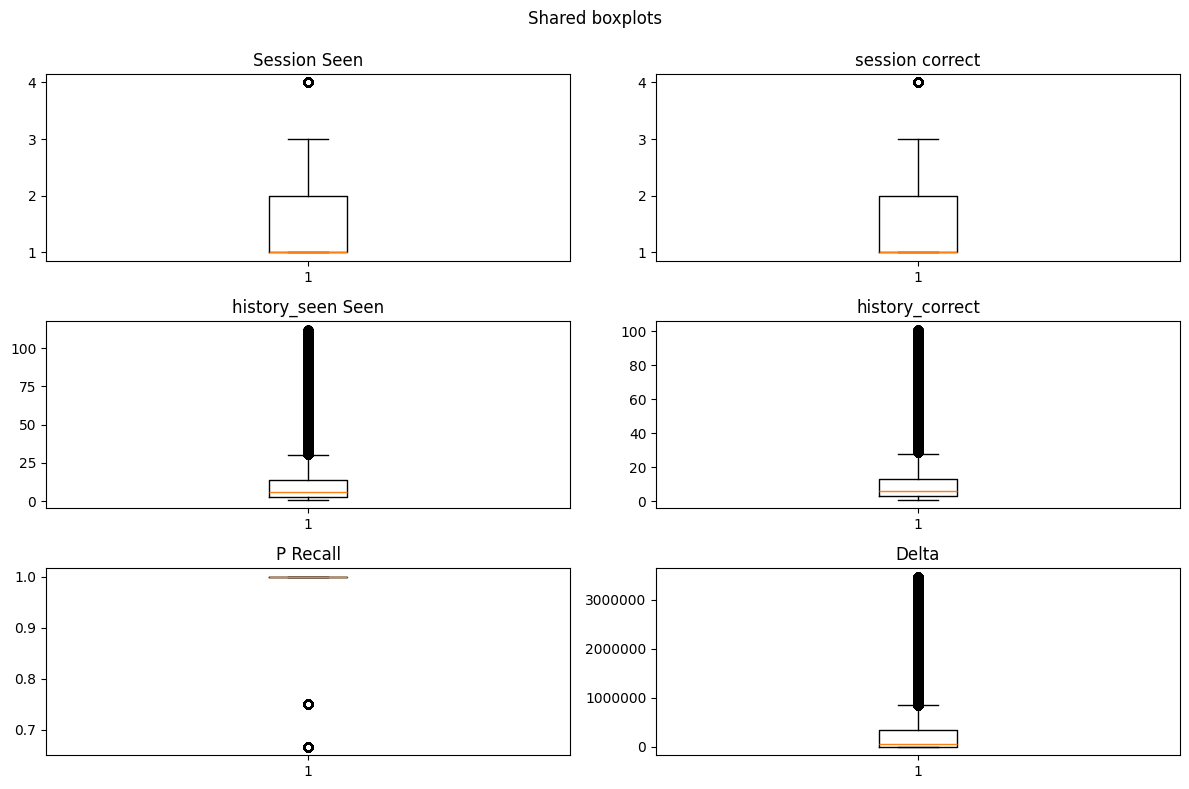

In [34]:
# Boxplots 

fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Plot each boxplot on the correct subplot
axs[0,0].boxplot(df['session_seen'])
axs[0,0].set_title('Session Seen')

axs[0,1].boxplot(df['session_correct'])
axs[0,1].set_title('session correct')

axs[1,0].boxplot(df['history_seen'])
axs[1,0].set_title('history_seen Seen')

axs[1,1].boxplot(df['history_correct'])
axs[1,1].set_title('history_correct')

axs[2,0].boxplot(df['p_recall'])
axs[2,0].set_title('P Recall')

axs[2,1].boxplot(df['delta'])
axs[2,1].set_title('Delta')

plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Shared boxplots')
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust the top to make room for the super title

plt.show()

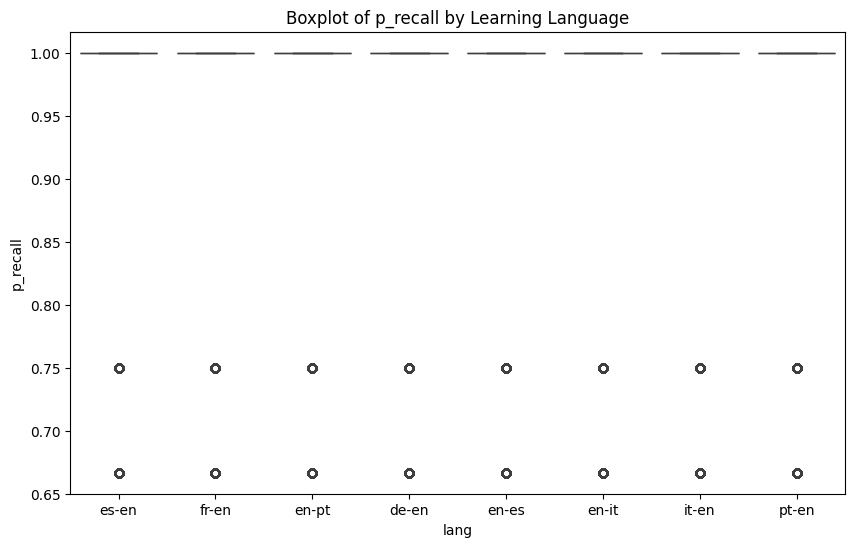

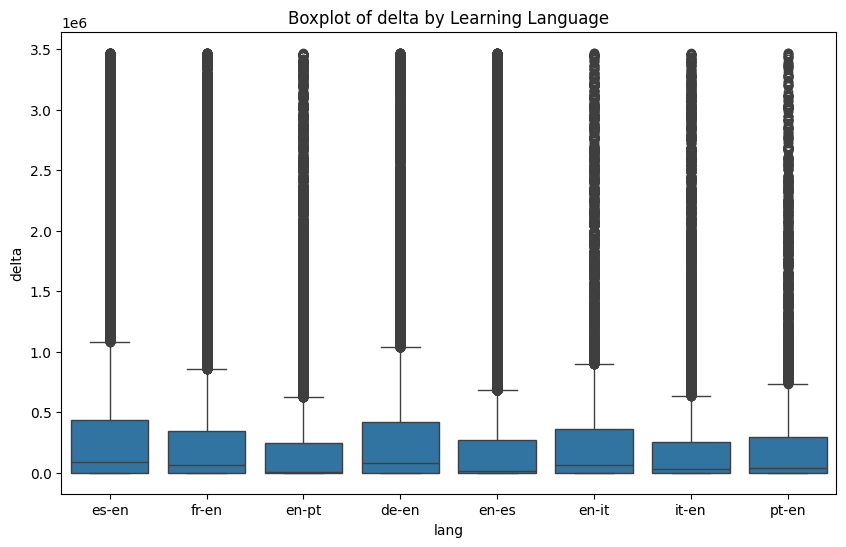

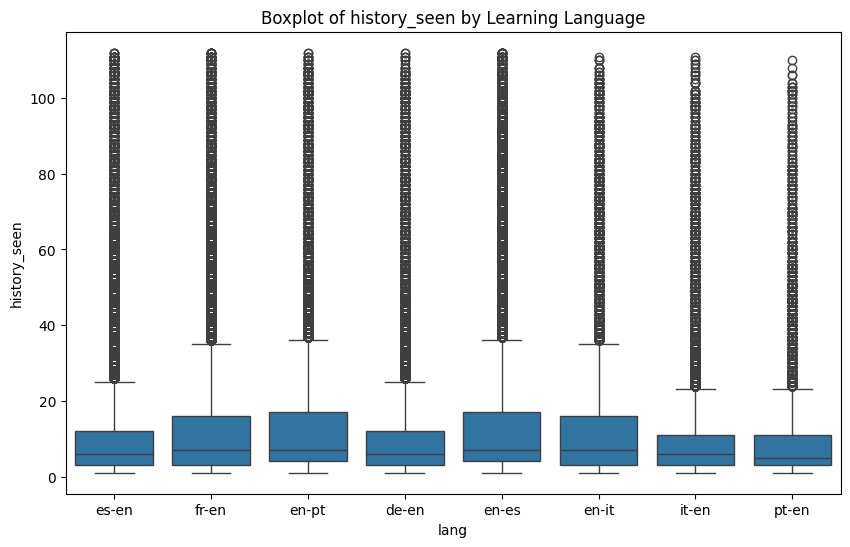

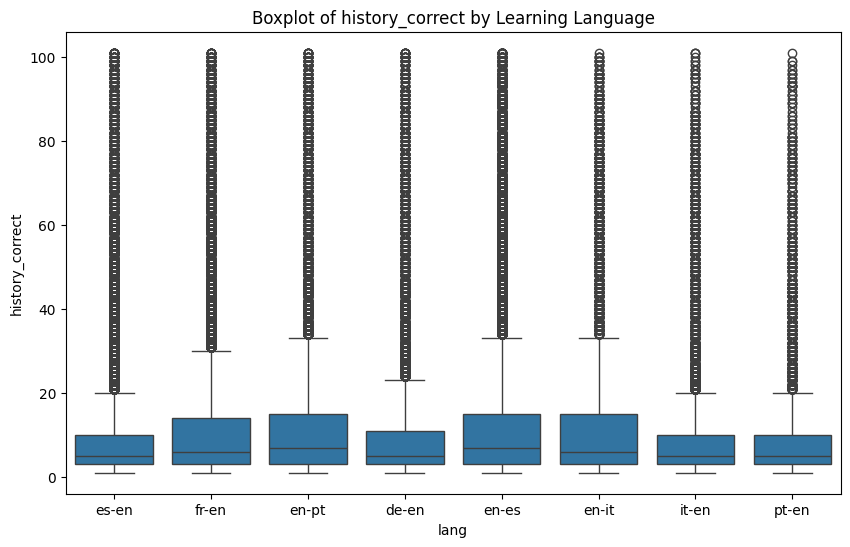

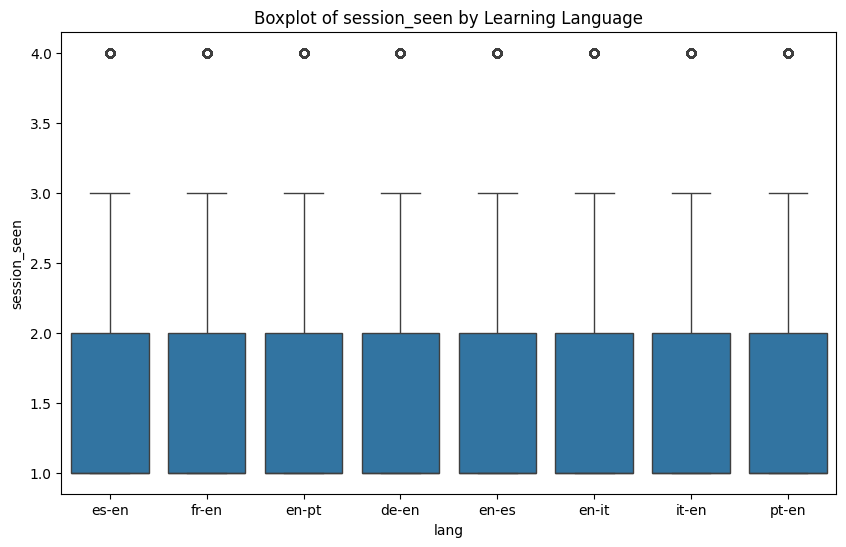

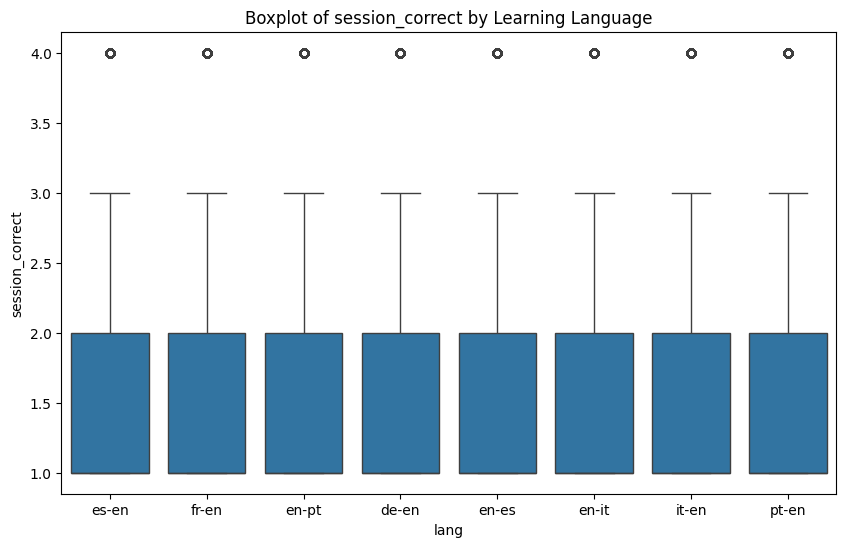

In [36]:
# Boxplots one by one
for y in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="lang", y=y, data=df)
    plt.title(f'Boxplot of {y} by Learning Language')
    plt.show()


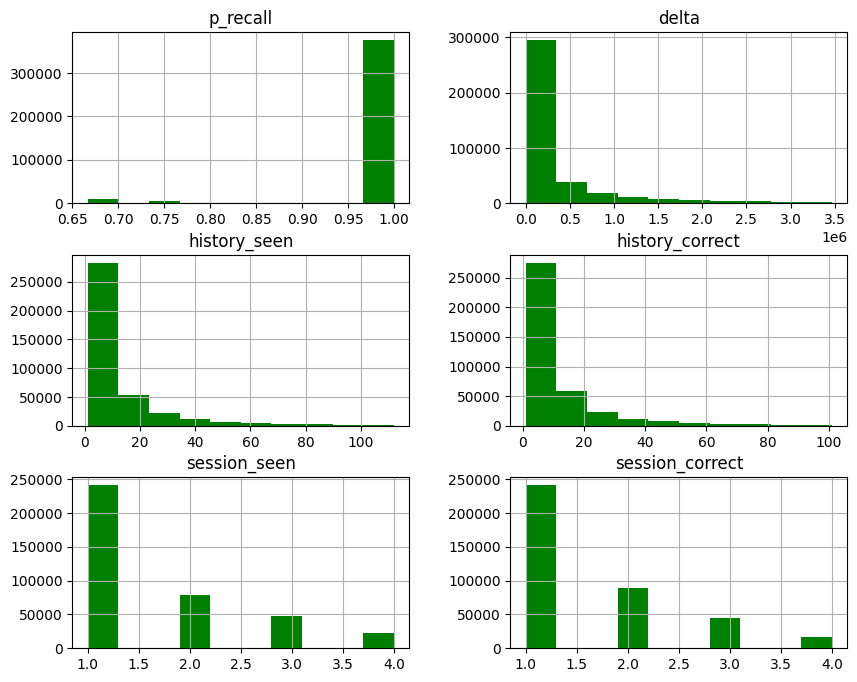

In [37]:
# Histograms
df[features].hist(figsize=(10,8), color='green')
plt.ticklabel_format(style = 'plain')

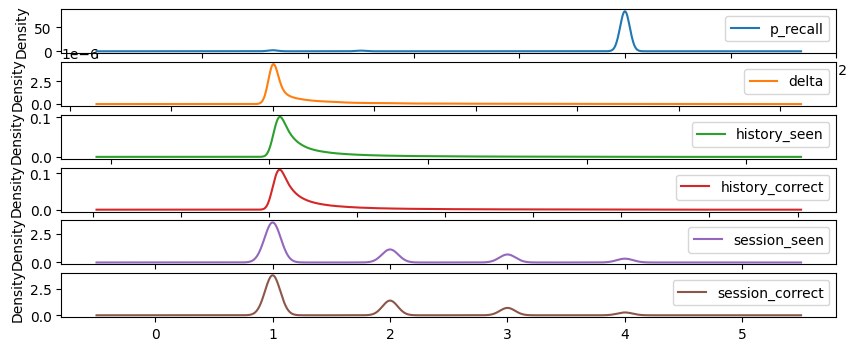

In [41]:
df[features].plot(kind='density',subplots=True,
                  sharex=False,figsize=(10,4))
plt.tight_layout
plt.show()


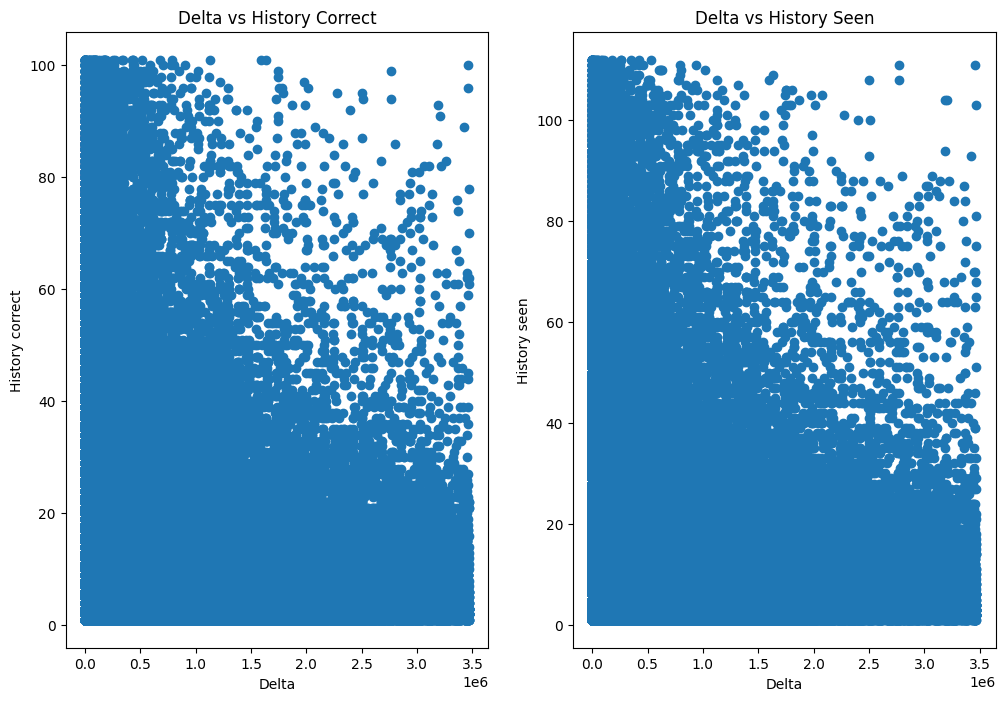

In [65]:
# Relationship -> delta with things 

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].scatter(df['delta'], df['history_correct'])
axs[0].set_xlabel('Delta')
axs[0].set_ylabel('History correct')
axs[0].set_title('Delta vs History Correct')


axs[1].scatter(df['delta'], df['history_seen'])
axs[1].set_xlabel('Delta')
axs[1].set_ylabel('History seen')
axs[1].set_title('Delta vs History Seen')

plt.show()

[Text(0.5, 0, 'p_recall'),
 Text(1.5, 0, 'delta'),
 Text(2.5, 0, 'history_seen'),
 Text(3.5, 0, 'history_correct'),
 Text(4.5, 0, 'session_seen'),
 Text(5.5, 0, 'session_correct')]

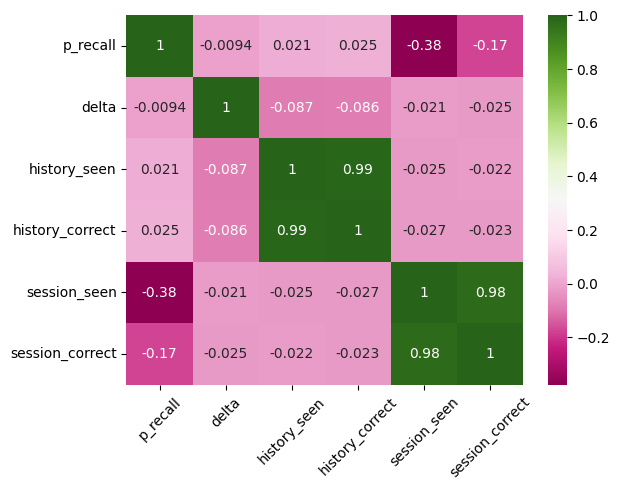

In [61]:
ax = sns.heatmap(df_numeric.corr(), cmap="PiYG", annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [78]:

# Divide 
df2 = df.copy()
learning_languages = df2['learning_language'].unique()
ui_languages = df2['ui_language'].unique()
lang_combinations = df2['lang'].unique()

# for l_lang in learning_languages:
#     df2['l_lang_'+l_lang] = df2['learning_language'].apply(lambda s: int(l_lang in s))

# for ui_lang in ui_languages:
#     df2['ui_lang_'+ui_lang] = df2['ui_language'].apply(lambda s: int(ui_lang in s))

for lang in lang_combinations:
    df2[lang] = df2['lang'].apply(lambda s: int(lang in s))

df2.drop(columns=['learning_language', 'ui_language', 'lang'])
df2.head()

,p_recall,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,lang,es-en,fr-en,en-pt,de-en,en-es,en-it,it-en,pt-en
0,1.0,894695,u:irDJ,es,en,2d8e4defa44f2512883a85f2c0ea46b4,ropa/ropa<n><f><sg>,1,1,2,2,es-en,1,0,0,0,0,0,0,0
1,1.0,1134,u:eTel,fr,en,be70637289b60b17de3b22270462e5bf,un/un<det><ind><m><sg>,42,39,2,2,fr-en,0,1,0,0,0,0,0,0
3,1.0,1081,u:h8c3,en,pt,17632879145d3e2737d11a3a5053dd50,his/his<det><pos><sp>,2,2,1,1,en-pt,0,0,1,0,0,0,0,0
4,1.0,58249,u:P03,de,en,2ac4ffe95f75b15d1d99aeebbb8321c7,ist/sein<vbser><pri><p3><sg>,4,4,2,2,de-en,0,0,0,1,0,0,0,0
5,1.0,17363,u:iUaS,es,en,3c317e367d8d299c237e618dd5dde5da,vino/vino<n><m><sg>,5,5,3,3,es-en,1,0,0,0,0,0,0,0
